---

# **Reinforcement Learning Black Jack** #

Kormishenkov Alexander, Ozerova Daria, Michael Kuznetsov


## Implementation of Jackblack environment

In [2]:
class Jackblack():

    def __init__(self):
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score}  # initial state
        self.actions = ("hit", "stick")

        init_state = self.state.copy()
        self.history = [init_state]  # game history, recording state and action of each step


    def step(self, action, verbose=False):
        #print('ENV STEP ACTION', action)
        self.history.append({"player": action})

        # player hits
        if action == "hit":
            value, colour = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, colour, self.state['player_score'])
            if verbose:
                print(f'Player draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append(new_state)

            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                if verbose:
                    print('Player goes bust')
                    print('Player loses')
                return self.state, reward, True

            else:
                reward = 0
                return self.state, reward, False

        # player sticks
        else:
            if verbose:
                    print(f'Player stops')
            new_state = self.state.copy()
            self.history.append(new_state)

            state, reward = self.dealer_moves(verbose)
            return self.state, reward, True


    def draw_card(self):
        value = random.randint(1, 10)
        colour = np.random.choice(['red','black'], size = 1, p=(1/3,2/3))[0]
        return value, colour


    def goes_bust(self, score):
        return ((score > 21) or (score < 1))


    def compute_new_score(self, value, colour, current_score):
        if colour == "black":
            new_score = current_score + value
        elif colour == "red":
            new_score = current_score - value
        return new_score


    def dealer_moves(self, verbose=True):
        while self.state['dealer_score'] < 17:
            value, colour = self.draw_card()
            self.state['dealer_score'] = self.compute_new_score(value, colour, self.state['dealer_score'])
            if verbose:
                print(f'Dealer draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)


            if self.goes_bust(self.state['dealer_score']):
                # dealer goes bust, player wins
                if verbose:
                    print('Dealer goes bust')
                    print('Dealer loses')
                reward = 1
                return self.state, reward

        self.history.append({"dealer": "stick"})

        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']

        # score > 17 -> dealer sticks
        if verbose:
            print('Dealer stops')
        if dealer_score < player_score: # player wins
            reward = 1
            if verbose:
                print('Player wins')
            return self.state, reward
        if dealer_score == player_score: # draw
            reward = 0
            if verbose:
                print('Draw')
            return self.state, reward
        if dealer_score > player_score: # player loses
            reward = -1
            if verbose:
                print('Dealer wins')
            return self.state, reward


    def print_score(self):
        for player in self.state.items():
            print(player[0] + ': ' + str(player[1]))

## DQN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque
from tqdm.notebook import tqdm  # или просто tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


class ReplayBuffer:
    def __init__(self, capacity=10_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=1e-3,
        gamma=0.99,
        batch_size=64,
        capacity=10_000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10_000,
        target_update_freq=1000
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.epsilon = self.epsilon_start
        self.step_count = 0
        self.target_update_freq = target_update_freq

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # target-сеть не тренируем

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(capacity)

        # ============ ДОБАВЛЕНО ДЛЯ СОХРАНЕНИЯ ЛОССОВ ============
        self.losses = []  # сюда сохраняем лосс после каждого update

    def select_action(self, state):
        """
        eps-жадная стратегия: 
        - с вероятностью epsilon берём случайное действие;
        - иначе берём action = argmax Q_network(s).
        """
        self.step_count += 1
        # плавное уменьшение epsilon
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start - (self.epsilon_start - self.epsilon_end) * (self.step_count / self.epsilon_decay)
        )

        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_t)
            action = q_values.argmax(dim=1).item()
            return action

    def update(self):
        """
        Обучаем Q-сеть на одном minibatch.
        """
        if len(self.replay_buffer) < self.batch_size:
            return

        # 1) сэмпл из буфера
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states_t = torch.FloatTensor(states).to(device)
        actions_t = torch.LongTensor(actions).to(device)
        rewards_t = torch.FloatTensor(rewards).to(device)
        next_states_t = torch.FloatTensor(next_states).to(device)
        dones_t = torch.FloatTensor(dones).to(device)

        # 2) Q(s,a)
        q_values = self.q_network(states_t)
        q_values = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

        # 3) Q-target для next state
        with torch.no_grad():
            q_next = self.target_network(next_states_t).max(dim=1)[0]
            q_target = rewards_t + self.gamma * q_next * (1 - dones_t)

        # 4) считаем лосс 
        loss = F.smooth_l1_loss(q_values, q_target)

        # 5) оптимизация
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 6) периодически копируем веса
        if self.step_count % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        # ====== ЗАПОМИНАЕМ ЛОСС ======
        self.losses.append(loss.item())

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)


In [90]:
def train_dqn(
    n_episodes=5_000,
    max_steps_per_episode=100,
    print_every=500
):
    # ИНИЦИАЛИЗИРУЕМ DQN-АГЕНТА
    dqn_agent = DQNAgent(
        state_dim=2,
        action_dim=2,  # "hit" или "stick"
        lr=1e-3,
        gamma=0.99,
        batch_size=256,
        capacity=10_000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=5_000,
        target_update_freq=500
    )

    all_rewards = []

    for episode in range(1, n_episodes + 1):
        env = Jackblack()
        state = np.array([env.state["dealer_score"], env.state["player_score"]], dtype=np.float32)

        total_reward = 0.0
        done = False

        for t in range(max_steps_per_episode):
            if done:
                break
            # Выбираем действие (0=hit, 1=stick)
            action_idx = dqn_agent.select_action(state)
            env_action = env.actions[action_idx]  # строка: "hit" или "stick"

            next_state_dict, reward, done = env.step(env_action)
            next_state = np.array([next_state_dict["dealer_score"], next_state_dict["player_score"]], dtype=np.float32)

            total_reward += reward

            # Сохраняем переход
            dqn_agent.remember(state, action_idx, reward, next_state, done)
            # Обновляем сеть
            dqn_agent.update()

            state = next_state

        all_rewards.append(total_reward)

        # Периодический вывод
        if episode % print_every == 0:
            avg_reward = np.mean(all_rewards[-print_every:])
            print(f"Episode {episode}, avg_reward: {avg_reward:.3f}, epsilon: {dqn_agent.epsilon:.3f}")

    return dqn_agent, all_rewards


In [91]:
def plot_loss_changes(losses, title="", xlabel="Episode", ylabel="Loss"):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Преобразуем лоссы (список float) в numpy-массив
    losses_np = np.array(losses, dtype=float)

    df = pd.DataFrame({
        xlabel: range(1, len(losses_np) + 1),
        ylabel: losses_np
    })
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=xlabel, y=ylabel)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [92]:
# Запустим тренировку
dqn_agent, episode_rewards = train_dqn(n_episodes=15000, max_steps_per_episode=100, print_every=500)


Episode 500, avg_reward: -0.098, epsilon: 0.843
Episode 1000, avg_reward: -0.024, epsilon: 0.680
Episode 1500, avg_reward: -0.010, epsilon: 0.520
Episode 2000, avg_reward: -0.020, epsilon: 0.370
Episode 2500, avg_reward: -0.080, epsilon: 0.221
Episode 3000, avg_reward: 0.022, epsilon: 0.075
Episode 3500, avg_reward: 0.052, epsilon: 0.010
Episode 4000, avg_reward: 0.050, epsilon: 0.010
Episode 4500, avg_reward: 0.120, epsilon: 0.010
Episode 5000, avg_reward: 0.050, epsilon: 0.010
Episode 5500, avg_reward: -0.006, epsilon: 0.010
Episode 6000, avg_reward: 0.098, epsilon: 0.010
Episode 6500, avg_reward: 0.070, epsilon: 0.010
Episode 7000, avg_reward: 0.008, epsilon: 0.010
Episode 7500, avg_reward: -0.040, epsilon: 0.010
Episode 8000, avg_reward: -0.016, epsilon: 0.010
Episode 8500, avg_reward: 0.038, epsilon: 0.010
Episode 9000, avg_reward: 0.054, epsilon: 0.010
Episode 9500, avg_reward: 0.036, epsilon: 0.010
Episode 10000, avg_reward: 0.048, epsilon: 0.010
Episode 10500, avg_reward: 0.030

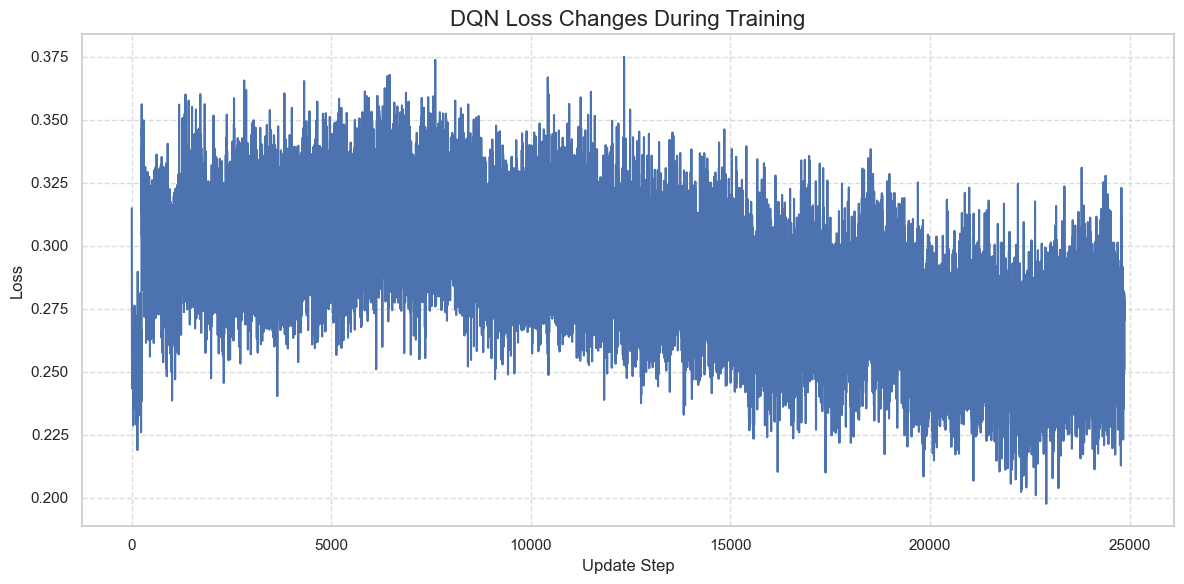

In [93]:
example_losses = dqn_agent.losses  # список float

plot_loss_changes(
    example_losses,
    title="DQN Loss Changes During Training",
    xlabel="Update Step",
    ylabel="Loss"
)


In [94]:
def calculate_cumulative_rewards(rewards_array):
    if not isinstance(rewards_array, (np.ndarray, list)):
        print("Invalid input: rewards_array must be a list or numpy array.")
        return None

    if isinstance(rewards_array, list):
        rewards_array = np.array(rewards_array)

    if rewards_array.ndim != 1:
        print("Invalid input: rewards_array must be 1 dimensional array or list.")
        return None

    cumulative_rewards = np.cumsum(rewards_array)
    return cumulative_rewards


def plot_cumulative_rewards(rewards_data, title="Cumulative Rewards During Training"):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    if isinstance(rewards_data, (np.ndarray, list)):
        if isinstance(rewards_data, list):
            rewards_data = np.array(rewards_data)

        if rewards_data.ndim != 1:
            print("Data is not 1 dimensional, can not convert to DataFrame")
            return

        cumulative_rewards = calculate_cumulative_rewards(rewards_data)
        if cumulative_rewards is None:
            return

        df = pd.DataFrame({
            'Episode': np.arange(1, len(cumulative_rewards) + 1), 
            'Cumulative Reward': cumulative_rewards
        })
    elif isinstance(rewards_data, pd.DataFrame):
        df = rewards_data.copy()
        if not all(col in df.columns for col in ['Episode', 'Cumulative Reward']):
            print('DataFrame need to contain columns: "Episode", "Cumulative Reward"')
            return
    else:
        print("Type of data is not supported, provide numpy array, list or Pandas DataFrame")
        return

    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Cumulative Reward', data=df, marker='o', ax=ax)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Reward', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.show()


Cumulative rewards example: [-1. -2. -1. -2. -3. -4. -3. -4. -3. -2.]


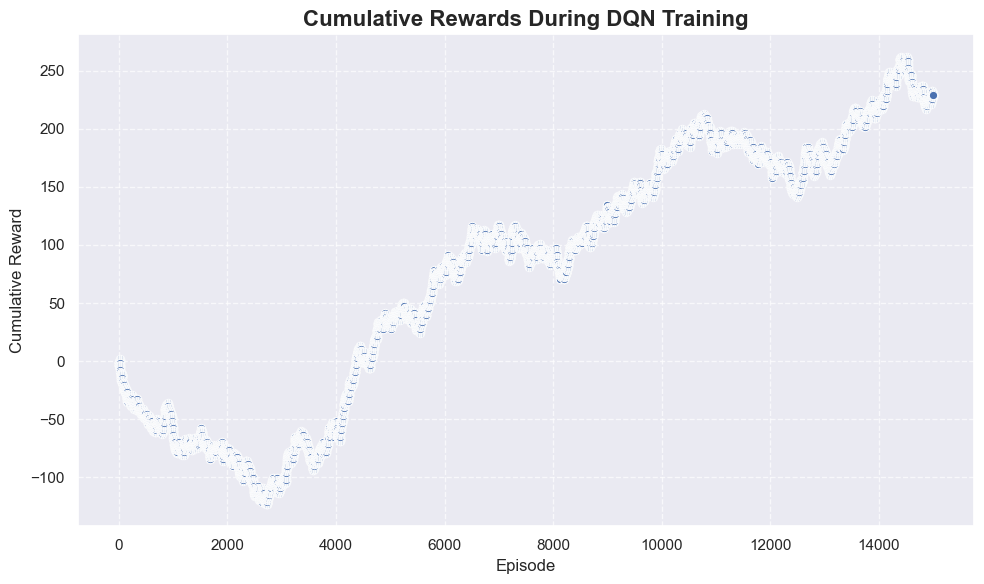

In [95]:
episode_rewards_arr = np.array(episode_rewards)

cumulative_rewards = calculate_cumulative_rewards(episode_rewards_arr)

if cumulative_rewards is not None:
    print("Cumulative rewards example:", cumulative_rewards[:10])
    plot_cumulative_rewards(episode_rewards_arr, title="Cumulative Rewards During DQN Training")


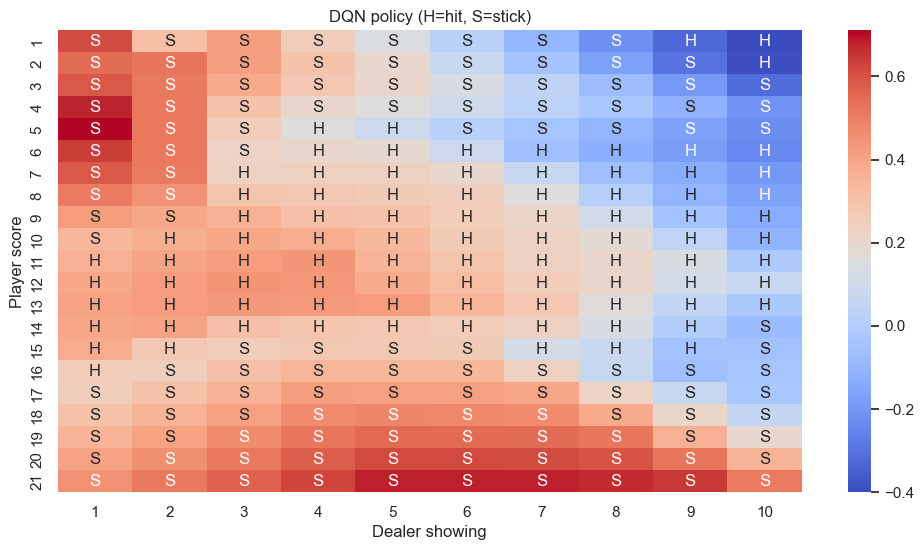

In [42]:
def plot_dqn_policy(action_table, q_values):
    dealer_showing = np.arange(1, 11)
    player_score   = np.arange(1, 22)

    matrix = pd.DataFrame(q_values, index=player_score, columns=dealer_showing)
    fig = plt.figure(figsize=(12,6))
    sns.heatmap(matrix, annot=action_table, fmt="", cmap='coolwarm')
    plt.title("DQN policy (H=hit, S=stick)")
    plt.xlabel("Dealer showing")
    plt.ylabel("Player score")
    plt.show()

plot_dqn_policy(best_actions, best_q)
